### 回测思路：sum(近远月仓位权重*对应月份合约收益率)，空头权重为负多头权重为正，(收益率+1).cumprod

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [7]:
def max_drawdown(date_series, capital_series):
    """
    计算最大回撤
    :param date_series: 日期序列
    :param capital_series: 收益序列
    :return:输出最大回撤及开始日期和结束日期
    """
    df = pd.DataFrame({'date': date_series, 'capital': capital_series})
    df.sort_values(by='date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['max2here'] = pd.Series.expanding(df['capital']).max()
    df['dd2here'] = df['capital'] / df['max2here'] - 1 
    temp = df.sort_values(by='dd2here').iloc[0][['date', 'dd2here']]
    max_dd = temp['dd2here']
    end_date = temp['date']

    df = df[df['date'] <= end_date]
    start_date = df.sort_values(by='capital', ascending=False).iloc[0]['date']
    return max_dd, start_date, end_date


def annual_return(date_series, capital_series, num_work):
    """
    计算年化收益率
    :param date_series: 日期序列
    :param capital_series:资产序列
    :return: 输出在回测期间的年化收益率
    """
    df = pd.DataFrame({'date': date_series, 'capital': capital_series})
    df.sort_values(by='date', inplace=True)
    df.reset_index(drop=True, inplace=True)

    annual = pow(df.loc[len(df.index) - 1, 'capital'] / df.loc[0, 'capital'], num_work / len(capital_series)) - 1
    return annual

def draw_plot(df, isshow=True):
    fig, axis = plt.subplots(2, 1, sharex=True)
    fig.set_size_inches(15, 8)
    ax1 = axis[0]
    ax2 = axis[1]

    p1, = ax1.plot(df.index, df['Hedge'], color='r', linewidth=2)
    p2, = ax1.plot(df.index, df['SPX500'], color='steelblue', linewidth=2)
    f1 = ax1.fill_between(df.index, df['SHORT'], 0, facecolor='gray', alpha=0.3) 
    title1 = 'Cumulative Return from %s to %s' % (df.index.astype(str)[0], df.index.astype(str)[-1])
    ax1.set_title(title1)
    ax1.legend([p1, p2, f1], ['Hedge', 'SPX500', 'SHORT'])
    ax1.grid(True) 
    ax2.set_xlim(df.index[0], df.index[-1])

    f2 = ax2.fill_between(df.index, df['MaxDD_Hedge'], 0, facecolor='r', alpha=0.5)
    f3 = ax2.fill_between(df.index, df['MaxDD_SPX'], 0, facecolor='steelblue', alpha=0.5)
    title2 = 'Drawdown from %s to %s' % (df.index.astype(str)[0], df.index.astype(str)[-1])
    ax2.legend([f2, f3], ['MaxDD_Hedge', 'MaxDD_SPX'], loc=3)
    ax2.set_title(title2)
    ax2.grid(True)
    ax2.set_xlim(df.index[0], df.index[-1])
    if isshow == True:
        plt.show()

In [3]:
df = pd.read_excel('output.xlsx', index_col=0)
select_col = df.columns.tolist()[:-9]
df[select_col] = df[select_col].apply(lambda x: x.pct_change().fillna(0))
select_col = select_col[:-2]

df['Total_Pos'] = abs(df['LONG_2'] - df['SHORT_2']) + df['LONG_3'] +  df['SHORT_1'] 
df['POS_1'] = -df['SHORT_1'] / df['Total_Pos']
df['POS_2'] = (df['LONG_2'] - df['SHORT_2']) / df['Total_Pos']
df['POS_3'] = df['LONG_3'] / df['Total_Pos']

months = list(np.unique([m[:-3] for m in df.index.astype(str).tolist()]))

out_df = pd.DataFrame()
for m in tqdm(months[:-1]):
    sub_df = df[m]
    weight = sub_df.iloc[:, -3:]
    if m < '2020-01':
        if int(m[2:4]) < 9:
            col = [x for x in select_col if m[2:4] in x] + [x for x in select_col if ('0'+str(int(m[2:4])+1)) in x][:3]
        if int(m[2:4]) < 19:
            col = [x for x in select_col if m[2:4] in x] + [x for x in select_col if str(int(m[2:4])+1) in x][:3]
        if int(m[2:4]) == 19:
            col = [x for x in select_col if m[2:4] in x] + select_col[-12:-9]
    else:
        col = select_col[-12:]
        
    sub = sub_df[col]
    start_col = int(m[-2:])
    end_col = int(m[-2:]) + 3

    sub_df['Hedge'] = (sub.iloc[:, start_col:end_col].values * weight.values).sum(axis=1)
    # 排除做多仓位
    weight['POS_1'] = weight['POS_1'].apply(lambda x: 0 if x>0 else x)
    weight['POS_2'] = weight['POS_2'].apply(lambda x: 0 if x>0 else x)
    sub_df['Short_Return'] = (sub.iloc[:, start_col:(end_col-1)].values * weight[['POS_1', 'POS_2']].values).sum(axis=1)
    sub_df['Long_Return'] = sub_df['Hedge'] - sub_df['Short_Return']
    out_df = out_df.append(sub_df)

out_df.to_excel('hedge.xlsx')

out_df[['VIX', 'SPX500', 'Hedge','Short_Return', 'Long_Return']] = out_df[['VIX', 'SPX500', 'Hedge','Short_Return', 'Long_Return']].apply(lambda x: (x+1).cumprod())
out_df['MaxDD_Hedge'] = out_df['Hedge'] / out_df['Hedge'].cummax() - 1
out_df['MaxDD_SPX'] = out_df['SPX500'] / out_df['SPX500'].cummax() - 1
out_df[['Hedge', 'SPX500']] = out_df[['Hedge', 'SPX500']].apply(lambda x: 100*x)

100%|████████████████████████████████████████████████████████████████████████████████| 164/164 [00:02<00:00, 73.64it/s]


In [4]:
print('Max Drawdown: ', max_drawdown(out_df.index.tolist(), out_df['Hedge']))
print('Annual Return: ', annual_return(out_df.index.tolist(), out_df['Hedge'], 250))

Max Drawdown:  (-0.5381589725565579, Timestamp('2014-01-21 00:00:00'), Timestamp('2018-04-24 00:00:00'))
Annual Return:  0.11895686522825955


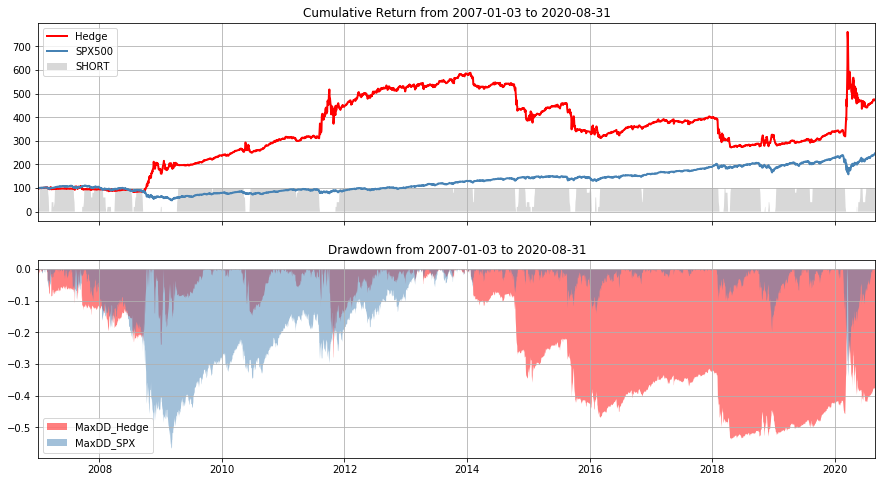

In [8]:
draw_plot(out_df)

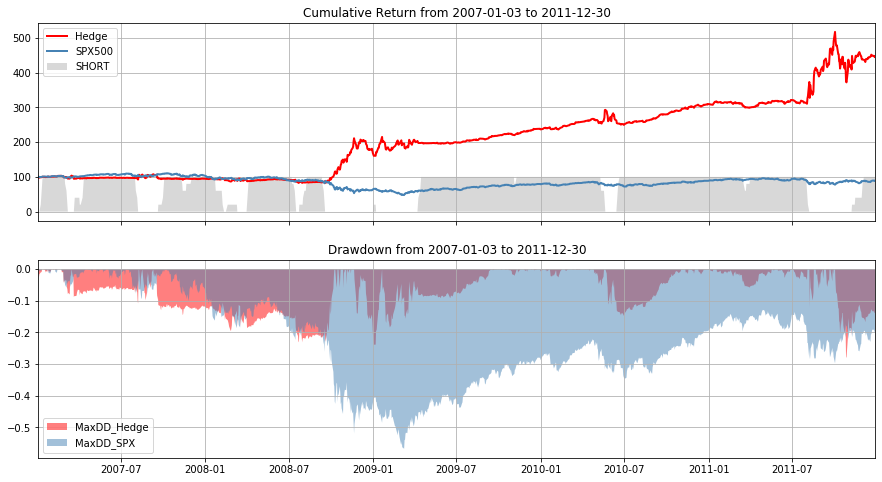

In [9]:
draw_plot(out_df[:'2011'])

In [118]:
def _generate_position(data):
    data.Date = pd.to_datetime(data.Date).apply(lambda x: x.strftime("%Y-%m-%d"))
    data = data[data.Date >= '2007-01-03']
    data = data.set_index("Date")
    position = pd.DataFrame(columns=['pos'])
    for t in data.index:
        con = _get_trade_contract(data, t)
        first = con[con == 1].index[0]
        second = con[con == 2].index[0]
        third = con[con == 3].index[0]
        pos = {first: -data.loc[t, 'SHORT_1'],
               second: data.loc[t, 'LONG_2'] - data.loc[t, 'SHORT_2'],
               third: data.loc[t, 'LONG_3']}
        position.loc[t, 'pos'] = [pos]
    position.index.name = 'Date'
    return position

In [120]:
df0 = _generate_position(data)

In [123]:
pos = df0.loc['2007-01-04', 'pos'][0]

In [125]:
for s in pos:
    print(abs(pos[s]))

0.0
90.0
10.0


In [126]:
pos

{'UXG07': -0.0, 'UXH07': 90.0, 'UXJ07': 10.0}